In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import stats
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

out_p = pd.read_csv('../data/data/Medicare_Charge_Outpatient_APC28_CY2015_Provider.csv')
in_p= pd.read_csv('../data/data/Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv')

## _2015 In Patient Cost & Star Ratings_

### _Project Template_
> ####  1.  EDA for Medicare in and out patient utilization provider data from 2015.
> ####  2.  Create methodolgy to recreate CMS provider star ratings system to correct discrepancies using hydrus and rstarrating.
> ####  3.  Build interface with power BI, comparing costs with overral hospital ratings within a market. 

##### _Discrepancies found in CMS's current star rating methodology_
> #####  1.  They compare critical access to acute care hospitals when they have vastly different patient populations and volume of reporting measures. Critical access hospitals reported just 27 of the 57 total measures while Acute care Hospitals on average reported 50 + of the 57 total, putting them at a sevre disadvantage (more oppurtunities to recevie a lower rating in one category and disrupt the total start-level rating). See http://www.modernhealthcare.com/article/20180314/NEWS/180319952
> #####  2.  They initially used non-adaptive latent variable modeling which changes the weights every time the model is run due to the sas pack use of Gaussian quadrature to approximate these integrals, resulting in a switch to adaptive latent variable modeling in December of 2017 and prior. Further the k means clustering is converged (originally only ran one iteration and failed to converge). See http://www.modernhealthcare.com/article/20180615/TRANSFORMATION01/180619933
> #####  3.  CMS disproportionately weighed the PSI 90 aggregate measure to the tune of being able to remove all 7/8 of the other metrics and only changing 4% of the hospitals star ratings... can I replicate this to fix this problem? 

##### _Ideas to approach these problems? Utilizing both the Hydrus(python) and rstarrating(R) packages_
> #####  1.  Separate the acute care and critical access hospitals from each other and run the k means and LVM models on the two classes separately? How would this be presented in the final presentation?  
> #####  2.  Use adaptive LVM by avoiding quadrature altogether and instead calculating exact integrals. Make sure the k means converges. 
> #####  3.  Rebalance the measure loading to avoid the over weighing of PSI 90 within the safety group. 

In [2]:
in_p.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,11,1014783.45,171081.18,141193.91
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,AZ - Phoenix,28,382051.00,194081.39,167511.96
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50025,UNIVERSITY OF CALIFORNIA SAN DIEGO MEDICAL CENTER,200 WEST ARBOR DRIVE,SAN DIEGO,CA,92103,CA - San Diego,21,971881.48,324050.71,294419.62
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50100,SHARP MEMORIAL HOSPITAL,7901 FROST ST,SAN DIEGO,CA,92123,CA - San Diego,18,1517857.61,257177.33,233532.83
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,"SUTTER MEDICAL CENTER, SACRAMENTO",2825 CAPITOL AVENUE,SACRAMENTO,CA,95816,CA - Sacramento,17,1470341.06,346150.12,338472.00


In [3]:
#Checking for missingness. All cols are populated for both in and out patient. 
print(in_p.isnull().sum())
print(out_p.isnull().sum())

DRG Definition                                0
Provider Id                                   0
Provider Name                                 0
Provider Street Address                       0
Provider City                                 0
Provider State                                0
Provider Zip Code                             0
Hospital Referral Region (HRR) Description    0
Total Discharges                              0
Average Covered Charges                       0
Average Total Payments                        0
Average Medicare Payments                     0
dtype: int64
APC                          0
Provider_ID                  0
Provider_Name                0
Provider_Street_Address      0
Provider_City                0
Provider_State               0
Provider_Zip_Code            0
Hospital_Referral_Region     0
Outpatient_Services          0
Average_Submitted_Charges    0
Average_Total_Payments       0
dtype: int64


### _What are the total costs, cost per unit (discharge), & difference between what charges were submitted and eventually paid out from Medicare for each APC/DRG?_

#### _Outpatient_

In [4]:
out_p.columns

Index(['APC', 'Provider_ID', 'Provider_Name', 'Provider_Street_Address',
       'Provider_City', 'Provider_State', 'Provider_Zip_Code',
       'Hospital_Referral_Region', 'Outpatient_Services',
       'Average_Submitted_Charges', 'Average_Total_Payments'],
      dtype='object')

In [5]:
out_p['Average_Charge_Paid_Difference'] = (out_p['Average_Submitted_Charges'] - out_p['Average_Total_Payments'])
out_p['Percentage_Covered_by_Medicare'] = (out_p['Average_Total_Payments'] / out_p['Average_Submitted_Charges'])

In [6]:
out_p.head(3)

,APC,Provider_ID,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region,Outpatient_Services,Average_Submitted_Charges,Average_Total_Payments,Average_Charge_Paid_Difference,Percentage_Covered_by_Medicare
0,0012 - Level I Debridement & Destruction,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,48,456.165625,52.018333,404.147292,0.114034
1,0012 - Level I Debridement & Destruction,10005,Marshall Medical Center South,2505 U S Highway 431 North,Boaz,AL,35957,AL - Birmingham,56,281.646429,16.993036,264.653393,0.060335
2,0012 - Level I Debridement & Destruction,10007,Mizell Memorial Hospital,702 N Main St,Opp,AL,36467,AL - Dothan,21,594.345238,78.740000,515.605238,0.132482


In [7]:
out_p.to_csv('../data/outpatient_2015.csv', sep='\t', encoding='utf-8')

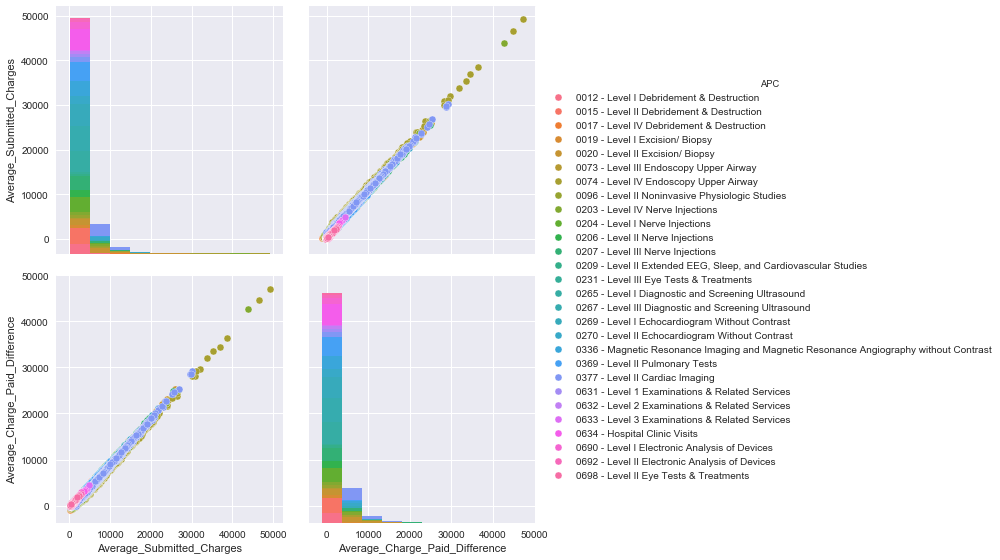

In [8]:
# Pairplot to look at a few features
ax = sns.pairplot(out_p[['Average_Submitted_Charges', 'APC', 'Average_Charge_Paid_Difference']], 
             hue='APC', 
             size=4)

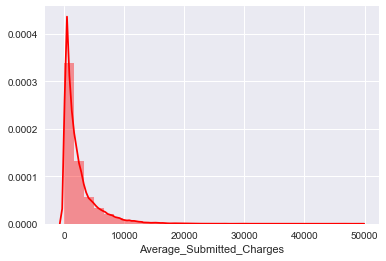

In [9]:
sns.distplot(out_p['Average_Submitted_Charges'], bins = 30, color = 'red')

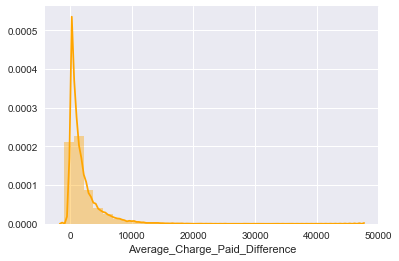

In [10]:
sns.distplot(out_p['Average_Charge_Paid_Difference'], bins = 30, color = 'orange')

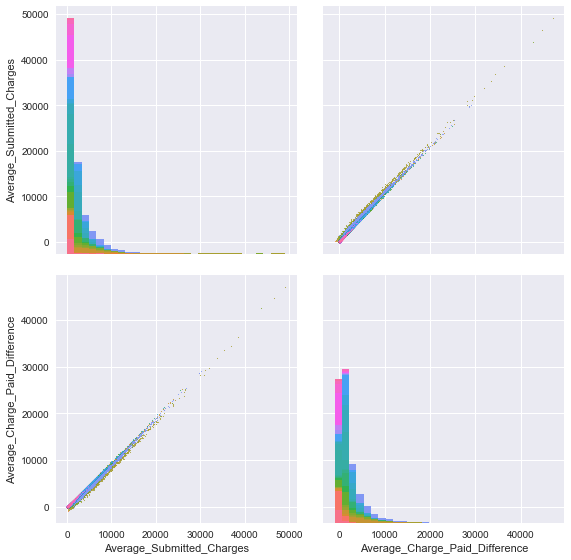

In [11]:
ax = sns.PairGrid(out_p[['Average_Submitted_Charges', 'APC', 'Average_Charge_Paid_Difference']], 
             hue='APC',
             size = 4)
ax.map_diag(plt.hist, bins = 30)
ax.map_offdiag(plt.scatter, s=0.5)

#### _Inpatient_ 

In [12]:
in_p.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region (HRR) Description',
       'Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments'],
      dtype='object')

In [13]:
in_p.columns = ['DRG', 'Provider_ID', 'Provider_Name', 'Provider_Address', 'Provider_City', 'Provider_State', 'Provider_Zip', 'Market', 'Total_Discharges', 'Average_Covered_Charges', 'Average_Total_Payments', 'Average_Medicare_Payments']

In [14]:
in_p['Percentage_Covered_by_Medicare'] = (in_p['Average_Medicare_Payments'] / in_p['Average_Total_Payments'])
in_p['Difference_Not_Covered'] = (in_p['Average_Total_Payments'] - in_p['Average_Medicare_Payments'])

In [15]:
in_p.head()

,DRG,Provider_ID,Provider_Name,Provider_Address,Provider_City,Provider_State,Provider_Zip,Market,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Percentage_Covered_by_Medicare,Difference_Not_Covered
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,11,1014783.45,171081.18,141193.91,0.825304,29887.27
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,AZ - Phoenix,28,382051.00,194081.39,167511.96,0.863102,26569.43
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50025,UNIVERSITY OF CALIFORNIA SAN DIEGO MEDICAL CENTER,200 WEST ARBOR DRIVE,SAN DIEGO,CA,92103,CA - San Diego,21,971881.48,324050.71,294419.62,0.908560,29631.09
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50100,SHARP MEMORIAL HOSPITAL,7901 FROST ST,SAN DIEGO,CA,92123,CA - San Diego,18,1517857.61,257177.33,233532.83,0.908061,23644.50
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASS...,50108,"SUTTER MEDICAL CENTER, SACRAMENTO",2825 CAPITOL AVENUE,SACRAMENTO,CA,95816,CA - Sacramento,17,1470341.06,346150.12,338472.00,0.977819,7678.12


In [16]:
in_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201876 entries, 0 to 201875
Data columns (total 14 columns):
DRG                               201876 non-null object
Provider_ID                       201876 non-null int64
Provider_Name                     201876 non-null object
Provider_Address                  201876 non-null object
Provider_City                     201876 non-null object
Provider_State                    201876 non-null object
Provider_Zip                      201876 non-null int64
Market                            201876 non-null object
Total_Discharges                  201876 non-null int64
Average_Covered_Charges           201876 non-null float64
Average_Total_Payments            201876 non-null float64
Average_Medicare_Payments         201876 non-null float64
Percentage_Covered_by_Medicare    201876 non-null float64
Difference_Not_Covered            201876 non-null float64
dtypes: float64(5), int64(3), object(6)
memory usage: 21.6+ MB


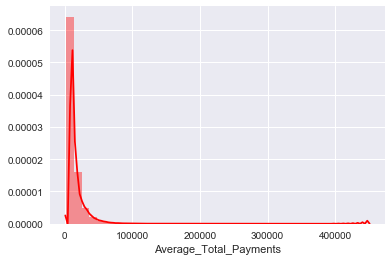

In [17]:
sns.distplot(in_p['Average_Total_Payments'], bins = 40, color = 'red')

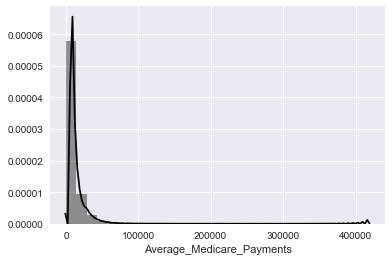

In [18]:
sns.distplot(in_p['Average_Medicare_Payments'], bins = 30, color = 'black')

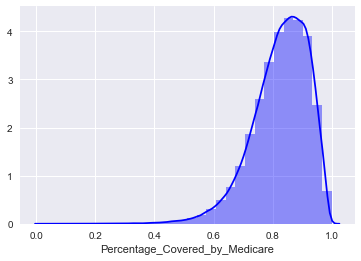

In [19]:
sns.distplot(in_p['Percentage_Covered_by_Medicare'], bins = 30, color = 'blue')

In [20]:
# ax = sns.PairGrid(in_p[['Cost per Discharge', 'Total Cost', 'DRG Definition', 'Costs covered by Medicare']], 
#              hue='DRG Definition',
#              size = 4)
# ax.map_diag(plt.hist, bins = 30)
# ax.map_offdiag(plt.scatter, s=0.5)

In [21]:
#in_p.to_csv('../data/inpatient_2015_1.csv', sep='\t', encoding='utf-8')

In [22]:
#May need to go to actual address level beacuse their ar multiple providers in a few zips. 
print(len(in_p['Provider_Name'].unique()))

3111


In [23]:
print(len(in_p['Provider_Zip'].unique()))

2941


#### _Separating Hospital Types_

In [24]:
#Can I clarify the difference between acute care and critical access?
gen = pd.read_csv('../data/data/Hospital_General_Information.csv')

In [25]:
gen.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Same as the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Below the national average,NaN,"2505 U S HIGHWAY 431 NORTH\nBOAZ, AL 35957\n"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,"200 MED CENTER DRIVE\nFORT PAYNE, AL 35968\n"
2,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,...,NaN,Below the national average,NaN,Same as the national average,NaN,Below the national average,NaN,Same as the national average,NaN,"ONE HOSPITAL DR SE\nHUNTSVILLE, AL 35801\n"
3,11304,CHOCTAW GENERAL HOSPITAL,"401 VANITY FAIR LANE, PO BOX 618",BUTLER,AL,36904,CHOCTAW,2054599100,Critical Access Hospitals,Voluntary non-profit - Private,...,Results are not available for this reporting p...,Not Available,There are too few measures or measure groups r...,Same as the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"401 VANITY FAIR LANE, PO BOX 618\nBUTLER, AL 3..."
4,20018,YUKON KUSKOKWIM DELTA REG HOSPITAL,PO BOX 287,BETHEL,AK,99559,BETHEL,9075436300,Acute Care Hospitals,Tribal,...,NaN,Below the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,Not Available,There are too few measures or measure groups r...,"PO BOX 287\nBETHEL, AK 99559\n"


In [26]:
gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798 entries, 0 to 4797
Data columns (total 29 columns):
Provider ID                                                      4798 non-null int64
Hospital Name                                                    4798 non-null object
Address                                                          4798 non-null object
City                                                             4798 non-null object
State                                                            4798 non-null object
ZIP Code                                                         4798 non-null int64
County Name                                                      4783 non-null object
Phone Number                                                     4798 non-null int64
Hospital Type                                                    4798 non-null object
Hospital Ownership                                               4798 non-null object
Emergency Services                  

In [27]:
print(len(gen['Hospital Name'].unique()))

4613


In [28]:
#How many of each type? 
#Acute Care - larger, teaching facilities with a traditionally lower-income patient population
#Critical access - smaller, more specialized facilities that serve a tradionally higher-income patient population
gen['Hospital Type'].value_counts()

Acute Care Hospitals         3355
Critical Access Hospitals    1345
Childrens                      98
Name: Hospital Type, dtype: int64

In [29]:
#Isolate hospital type with provider ID
id_type = gen[['Provider ID', 'Hospital Type']]

In [30]:
id_type.head(5)

,Provider ID,Hospital Type
0,10005,Acute Care Hospitals
1,10012,Acute Care Hospitals
2,10131,Acute Care Hospitals
3,11304,Critical Access Hospitals
4,20018,Acute Care Hospitals


In [31]:
id_type.columns.values[0] = 'Provider_ID'

In [32]:
ach = id_type.loc[id_type['Hospital Type'] == 'Acute Care Hospitals']
cah = id_type.loc[id_type['Hospital Type'] == 'Critical Access Hospitals']
child = id_type.loc[id_type['Hospital Type'] == 'Childrens']

In [33]:
#Exporting to R 
#Using separate hospital type input files to generate ratings 
#ach.to_csv('../data/data/ach.csv', encoding='utf-8')
#cah.to_csv('../data/data/cah.csv', encoding='utf-8')

In [34]:
in_p.columns

Index(['DRG', 'Provider_ID', 'Provider_Name', 'Provider_Address',
       'Provider_City', 'Provider_State', 'Provider_Zip', 'Market',
       'Total_Discharges', 'Average_Covered_Charges', 'Average_Total_Payments',
       'Average_Medicare_Payments', 'Percentage_Covered_by_Medicare',
       'Difference_Not_Covered'],
      dtype='object')

In [35]:
print(len(in_p['Provider_ID'].unique()))

3231


#### _Isolating Oct 2016 CMS Star Ratings for the hospitals we have cost information for_

In [67]:
gen_2016 = pd.read_csv('../data/data/Hospital_General_Information_Oct_2016.csv')

In [73]:
cms_2016_ratings = gen_2016[['Provider ID', 'Hospital Type', 'Hospital overall rating']]

In [75]:
cms_2016_ratings.columns = ['Provider_ID', 'Hospital_Type', 'CMS_Rating']

In [79]:
cms_2016_ratings.head()

,Provider_ID,Hospital_Type,CMS_Rating
0,10001,Acute Care Hospitals,3
1,10005,Acute Care Hospitals,3
2,10006,Acute Care Hospitals,2
3,10007,Acute Care Hospitals,3
4,10008,Acute Care Hospitals,3


In [86]:
cms_2016_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 3 columns):
Provider_ID      4818 non-null int64
Hospital_Type    4818 non-null object
CMS_Rating       4818 non-null object
dtypes: int64(1), object(2)
memory usage: 113.0+ KB


#### _Combining CMS and suggeted ratings_

In [78]:
#Adding in suggested custom ratings from R
suggested_ratings = pd.read_csv('../data/R_ratings/suggested_star_ratings.csv')

In [80]:
suggested_ratings.columns = ['Provider_ID', 'Suggested_Rating']

In [81]:
ratings = pd.merge(cms_2016_ratings, suggested_ratings, how='inner', on=['Provider_ID'])

In [89]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3606 entries, 0 to 3605
Data columns (total 4 columns):
Provider_ID         3606 non-null int64
Hospital_Type       3606 non-null object
CMS_Rating          3606 non-null object
Suggested_Rating    3606 non-null int64
dtypes: int64(2), object(2)
memory usage: 140.9+ KB


In [83]:
ratings.head()

,Provider_ID,Hospital_Type,CMS_Rating,Suggested_Rating
0,10001,Acute Care Hospitals,3,2
1,10005,Acute Care Hospitals,3,2
2,10006,Acute Care Hospitals,2,2
3,10007,Acute Care Hospitals,3,3
4,10008,Acute Care Hospitals,3,3


In [88]:
print(ratings.Hospital_Type.value_counts())

Acute Care Hospitals         3026
Critical Access Hospitals     580
Name: Hospital_Type, dtype: int64


In [85]:
print(ratings.CMS_Rating.value_counts())
print(ratings.Suggested_Rating.value_counts())

3    1745
4     953
2     682
1     115
5     111
Name: CMS_Rating, dtype: int64
3    1190
4    1037
2     757
5     331
1     291
Name: Suggested_Rating, dtype: int64


In [93]:
#ratings.to_csv('../data/R_ratings/CMS_vs_Suggested.csv', sep='\t', encoding='utf-8')

#### _Combining star ratings with cost info_

In [90]:
merged = pd.merge(in_p, ratings, how='left', on=['Provider_ID'])

In [91]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201876 entries, 0 to 201875
Data columns (total 17 columns):
DRG                               201876 non-null object
Provider_ID                       201876 non-null int64
Provider_Name                     201876 non-null object
Provider_Address                  201876 non-null object
Provider_City                     201876 non-null object
Provider_State                    201876 non-null object
Provider_Zip                      201876 non-null int64
Market                            201876 non-null object
Total_Discharges                  201876 non-null int64
Average_Covered_Charges           201876 non-null float64
Average_Total_Payments            201876 non-null float64
Average_Medicare_Payments         201876 non-null float64
Percentage_Covered_by_Medicare    201876 non-null float64
Difference_Not_Covered            201876 non-null float64
Hospital_Type                     195713 non-null object
CMS_Rating                      

In [95]:
merged.to_csv('../data/data/2015_Ratings.csv', sep='\t', encoding='utf-8')